In [8]:
# 1) READ THE FILE
import pandas as pd
from pathlib import Path

FILEPATH = r"matches (1).csv"   # exact name

p = Path(FILEPATH)
assert p.exists(), f"Couldn't find {p.resolve()} — is your notebook in the same folder?"

# Try to parse a 'date' column if it exists
try:
    matches = pd.read_csv(p, parse_dates=["date"])
except Exception:
    matches = pd.read_csv(p)

# Standardize column names (lowercase, no extra spaces)
matches.columns = [c.strip().lower() for c in matches.columns]

print("Loaded:", p.resolve())
print("Shape:", matches.shape)
print("Columns:", matches.columns.tolist())
matches.head()


Loaded: /Users/krishmaisuria/Downloads/matches (1).csv
Shape: (1389, 28)
Columns: ['unnamed: 0', 'date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga', 'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation', 'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'season', 'team']


,unnamed: 0,date,time,comp,round,day,venue,result,gf,ga,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0.0,1.0,...,Match Report,NaN,18.0,4.0,16.9,1.0,0.0,0.0,2022,Manchester City
1,2,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5.0,0.0,...,Match Report,NaN,16.0,4.0,17.3,1.0,0.0,0.0,2022,Manchester City
2,3,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5.0,0.0,...,Match Report,NaN,25.0,10.0,14.3,0.0,0.0,0.0,2022,Manchester City
3,4,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1.0,0.0,...,Match Report,NaN,25.0,8.0,14.0,0.0,0.0,0.0,2022,Manchester City
4,6,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Home,D,0.0,0.0,...,Match Report,NaN,16.0,1.0,15.7,1.0,0.0,0.0,2022,Manchester City


In [7]:
# 2) CLEANING & SIMPLE FEATURES (pre-match only)
import numpy as np

# Minimal checks
need = {"date","venue","result"}
missing = need - set(matches.columns)
assert not missing, f"Missing required columns: {missing}"

# Try to infer team/opponent column names; edit these two if needed
TEAM_COL = next((c for c in ["team","squad","club","home_team"] if c in matches.columns), None)
OPP_COL  = next((c for c in ["opponent","opp","against","away_team"] if c in matches.columns), None)
assert TEAM_COL and OPP_COL, "Set TEAM_COL/OPP_COL to your actual column names."

# Sort by team then date so “previous game” really means previous in time
df = matches.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.sort_values([TEAM_COL, "date"]).reset_index(drop=True)

# Basic pre-match features (leakage-safe, no rolling yet)
df["venue_code"] = (df["venue"].astype(str).str.lower() == "home").astype(int)
df["opp_code"]   = df[OPP_COL].astype("category").cat.codes
df["hour"]       = df["date"].dt.hour.fillna(0).astype(int)
df["day_code"]   = df["date"].dt.weekday.astype(int)

# Target: map per-team W/D/L + venue -> match outcome H/D/A
def to_hda(res, ven):
    r = str(res).upper()
    if r == "D": return "D"
    if str(ven).lower() == "home": return "H" if r == "W" else "A"
    return "A" if r == "W" else "H"

df["target_hda"] = [to_hda(r, v) for r, v in zip(df["result"], df["venue"])]


print("Rows:", len(df), "| Date range:", df["date"].min(), "→", df["date"].max())
print("Class counts (H/D/A):")
print(df["target_hda"].value_counts())
df.head()


Rows: 1389 | Date range: 2020-09-12 00:00:00 → 2022-04-25 00:00:00
Class counts (H/D/A):
target_hda
H    556
A    518
D    315
Name: count, dtype: int64


,unnamed: 0,date,time,comp,round,day,venue,result,gf,ga,...,fk,pk,pkatt,season,team,venue_code,opp_code,hour,day_code,target_hda
0,1,2020-09-12,12:30,Premier League,Matchweek 1,Sat,Away,W,3.0,0.0,...,2.0,0.0,0.0,2021,Arsenal,0,8,0,5,A
1,2,2020-09-19,20:00,Premier League,Matchweek 2,Sat,Home,W,2.0,1.0,...,0.0,0.0,0.0,2021,Arsenal,1,21,0,5,H
2,4,2020-09-28,20:00,Premier League,Matchweek 3,Mon,Away,L,1.0,3.0,...,0.0,0.0,0.0,2021,Arsenal,0,11,0,0,H
3,6,2020-10-04,14:00,Premier League,Matchweek 4,Sun,Home,W,2.0,1.0,...,0.0,0.0,0.0,2021,Arsenal,1,16,0,6,H
4,7,2020-10-17,17:30,Premier League,Matchweek 5,Sat,Away,L,0.0,1.0,...,2.0,0.0,0.0,2021,Arsenal,0,12,0,5,H


In [6]:
# 3) MULTINOMIAL LOGISTIC REGRESSION (H/D/A)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report

# Feature set (simple, guaranteed to exist)
feature_cols = ["venue_code","opp_code","hour","day_code"]

# Time-ordered split (robust): last 20% of dates = test
cut = df["date"].quantile(0.80)
train = df[df["date"] <  cut].copy()
test  = df[df["date"] >= cut].copy()

X_train = train[feature_cols]; y_train = train["target_hda"].to_numpy()
X_test  = test[feature_cols];  y_test  = test["target_hda"].to_numpy()

print("Split sizes → train:", len(train), "| test:", len(test))

# Pipeline: scale → multinomial logistic regression (softmax)
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        multi_class="multinomial", solver="lbfgs",
        max_iter=1000, class_weight="balanced", random_state=42))
])

pipe.fit(X_train, y_train)
y_pred  = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)
classes = pipe.named_steps["clf"].classes_

# Metrics
print("\n=== Multinomial Logistic Regression (simple features) ===")
print("Classes:", list(classes))
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Log Loss:", round(log_loss(y_test, y_proba, labels=classes), 3))

print("\nConfusion matrix (rows=true, cols=pred):")
print(pd.DataFrame(confusion_matrix(y_test, y_pred, labels=classes),
                   index=[f"true_{c}" for c in classes],
                   columns=[f"pred_{c}" for c in classes]))

print("\nClassification report:")
print(classification_report(y_test, y_pred, labels=classes, zero_division=0))

# A quick sample of predictions
out = test[[TEAM_COL, OPP_COL, "date", "venue", "result"]].copy()
out["target_hda"] = test["target_hda"].values
out["pred_outcome"] = y_pred
out["pred_prob_max"] = y_proba.max(axis=1).round(3)
out.head(10)


Split sizes → train: 1107 | test: 282

=== Multinomial Logistic Regression (simple features) ===
Classes: ['A', 'D', 'H']
Accuracy: 0.372
Log Loss: 1.095

Confusion matrix (rows=true, cols=pred):
        pred_A  pred_D  pred_H
true_A      36      30      38
true_D      19      21      16
true_H      44      30      48

Classification report:
              precision    recall  f1-score   support

           A       0.36      0.35      0.35       104
           D       0.26      0.38      0.31        56
           H       0.47      0.39      0.43       122

    accuracy                           0.37       282
   macro avg       0.36      0.37      0.36       282
weighted avg       0.39      0.37      0.38       282



/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,team,opponent,date,venue,result,target_hda,pred_outcome,pred_prob_max
57,Arsenal,Manchester City,2022-01-01,Home,L,A,A,0.344
58,Arsenal,Burnley,2022-01-23,Home,D,D,A,0.356
59,Arsenal,Wolves,2022-02-10,Away,W,A,H,0.365
60,Arsenal,Brentford,2022-02-19,Home,W,H,A,0.348
61,Arsenal,Wolves,2022-02-24,Home,W,H,H,0.358
62,Arsenal,Watford,2022-03-06,Away,W,A,H,0.360
63,Arsenal,Leicester City,2022-03-13,Home,W,H,A,0.353
64,Arsenal,Liverpool,2022-03-16,Home,L,A,D,0.351
65,Arsenal,Aston Villa,2022-03-19,Away,W,A,D,0.348
66,Arsenal,Crystal Palace,2022-04-04,Away,L,H,D,0.384


In [9]:
from sklearn.metrics import accuracy_score, log_loss

acc = accuracy_score(y_test, y_pred)
ll  = log_loss(y_test, y_proba, labels=classes)
print(f"Accuracy: {acc:.3f}")
print(f"Log Loss: {ll:.3f}")

Accuracy: 0.372
Log Loss: 1.095


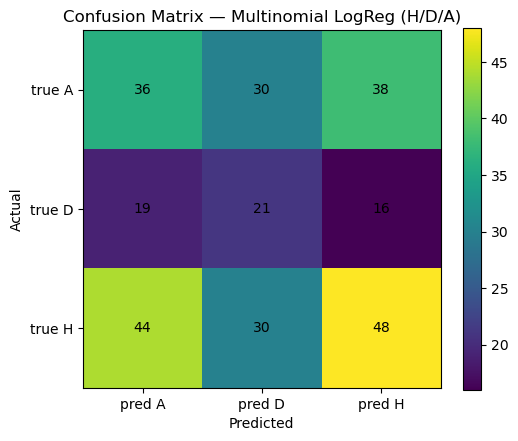

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=classes)

plt.figure(figsize=(5.5, 4.5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix — Multinomial LogReg (H/D/A)")
plt.xticks(ticks=np.arange(len(classes)), labels=[f"pred {c}" for c in classes])
plt.yticks(ticks=np.arange(len(classes)), labels=[f"true {c}" for c in classes])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()

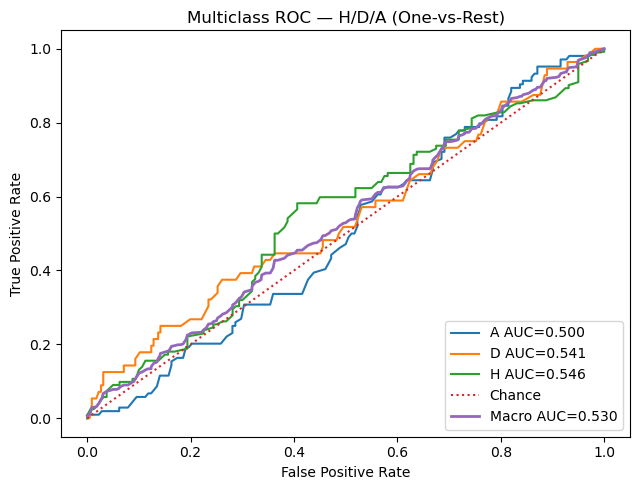

Macro-average ROC AUC: 0.530


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# binarize true labels
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# per-class curves
fpr, tpr, aucs = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    aucs[i] = auc(fpr[i], tpr[i])

# macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

plt.figure(figsize=(6.5, 5))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} AUC={aucs[i]:.3f}")
plt.plot([0,1], [0,1], linestyle=":", label="Chance")
plt.plot(all_fpr, mean_tpr, linewidth=2, label=f"Macro AUC={macro_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC — H/D/A (One-vs-Rest)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"Macro-average ROC AUC: {macro_auc:.3f}")
